In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read Data

In [2]:
data = pd.read_csv('/content/sample_data/sfr_test.csv')
data.sample(5)

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
6141,6142,F,17/02/1951,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,53,HMO,False,False,"$4,541.88","$4,929.47",$6.38,$322.31,$95.45,$470.81,$0.00,"$5,444.63",$0.00,$8.19,$0.00,$0.00,$0.00,$0.00,$0.00,$783.03
8259,8260,M,27/08/1938,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,70,HMO,False,False,"$11,325.98","$14,324.01",$14.17,"$1,365.13",$645.81,$484.03,$0.00,"$14,245.00",$0.00,$8.05,$0.00,"$14,334.82",$0.00,"$15,228.09","$14,690.46",$950.82
5138,5139,M,19/06/1961,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,38,HMO,False,False,"$12,672.60","$14,428.38",$16.12,$349.62,$631.46,$0.00,$0.00,"$13,904.65",$0.00,$9.39,$0.00,"$1,453.80",$0.00,"$1,372.51","$1,625.50",$813.48
8833,8834,F,26/08/1960,2020,202006,VIPcare,NON-SNP,NaN,78,HMO,False,False,"$5,273.38","$6,938.40",$5.58,$589.42,$215.21,$704.93,$0.00,"$6,744.72",$605.10,$8.56,$0.00,$65.29,$0.00,$71.41,$66.98,$802.36
7831,7832,M,23/08/1969,2020,202006,VIPcare,NON-SNP,NaN,67,HMO,False,False,"$6,674.79","$7,394.70",$6.95,$250.71,$284.14,$774.34,$0.00,"$7,772.24",$0.00,$8.68,$0.00,$0.00,$0.00,$0.00,$0.00,$620.35


In [3]:
s_df = data.copy()

# Format used columns
for c_name in s_df.columns[12:]:
    s_df[c_name] = s_df[c_name].str[1:]
    s_df[c_name] = s_df[c_name].str.replace(',', '').astype(float)

# transform float to int
s_df[['esrd', 'hospice']] = s_df[['esrd', 'hospice']].astype(int)

In [4]:
s_df.describe()

,member_unique_id,eligible_year,eligible_month,npi,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
count,10530.000000,10530.0,10530.0,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.0,10530.000000,10530.0,10530.000000,10530.000000,10530.000000
mean,5265.500000,2020.0,202006.0,44.351852,0.002564,0.001804,10657.849594,12311.727551,14.601082,500.425354,281.523642,507.875923,44.715122,12622.875903,407.262296,8.728322,0.0,2166.888445,0.0,2177.164111,2177.391484,811.940253
std,3039.893501,0.0,0.0,27.025010,0.050574,0.042442,7690.191694,8955.579076,11.398322,1130.533796,239.155174,269.436836,279.992983,9165.144567,1787.161653,0.505910,0.0,13570.047143,0.0,13867.469329,13775.436097,134.976209
min,1.000000,2020.0,202006.0,1.000000,0.000000,0.000000,1302.360000,1394.850000,0.000000,13.940000,8.620000,0.000000,0.000000,1295.180000,0.000000,7.910000,0.0,0.000000,0.0,0.000000,0.000000,578.320000
25%,2633.250000,2020.0,202006.0,21.000000,0.000000,0.000000,5390.645000,6200.255000,6.502500,197.210000,130.780000,503.020000,0.000000,6362.810000,0.000000,8.290000,0.0,0.000000,0.0,0.000000,0.000000,711.512500
50%,5265.500000,2020.0,202006.0,40.000000,0.000000,0.000000,8723.135000,10060.455000,11.740000,312.365000,220.590000,613.500000,0.000000,10317.105000,0.000000,8.690000,0.0,114.205000,0.0,115.150000,115.110000,775.110000
75%,7897.750000,2020.0,202006.0,68.000000,0.000000,0.000000,13444.632500,15479.840000,18.920000,499.352500,352.032500,684.260000,0.000000,15886.765000,0.000000,9.160000,0.0,536.537500,0.0,536.535000,536.355000,890.310000
max,10530.000000,2020.0,202006.0,93.000000,1.000000,1.000000,113850.930000,155112.650000,174.600000,32687.500000,3120.530000,833.330000,6056.440000,138352.500000,69516.960000,9.670000,0.0,557883.960000,0.0,570037.030000,588346.570000,1329.520000


In [5]:
# drop columns with no information value (as they have only 0s)
s_df = s_df.drop(columns=['rx_rebates', 'risk_score_partd'])
s_df.sample(5)

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,rx,rx_with_rebates,rx_without_rebates,spec_cap
8450,8451,F,03/09/1937,2020,202006,Affiliate,NON-SNP,NaN,72,HMO,0,0,9014.26,11813.64,12.33,7401.84,338.38,527.33,0.0,11122.24,0.00,8.11,60159.51,66482.40,60048.62,1150.81
9677,9678,M,19/09/1950,2020,202006,SaludVIP,NON-SNP,MEDICARE - CAREFREE,84,HMO,0,0,8775.67,9716.05,13.19,140.11,216.79,0.00,0.0,10447.23,0.00,8.28,138.29,153.90,142.06,670.87
8664,8665,M,19/07/1966,2020,202006,VIPcare,NON-SNP,NaN,75,HMO,0,0,4377.56,5331.92,3.02,496.23,209.25,666.03,0.0,5105.24,0.00,8.44,0.00,0.00,0.00,741.27
4384,4385,M,11/04/1952,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,33,HMO,0,0,11478.81,13064.17,20.29,151.12,454.56,0.00,0.0,13885.61,0.00,7.97,489.32,433.15,433.15,758.52
2474,2475,F,26/11/1942,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,20,HMO,0,0,11428.07,13513.98,16.91,501.96,256.05,587.14,0.0,15020.30,3214.33,9.10,951.66,780.92,857.45,881.72


Taking subset of data sa features for finding outliers


In [6]:
# change slicing to lower number of features or use list instead
c_names = s_df.columns[10:]
features = s_df[c_names]
features.sample(5)

,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,rx,rx_with_rebates,rx_without_rebates,spec_cap
1836,0,0,13661.02,14902.91,17.23,136.55,295.21,664.77,0.0,15063.17,0.0,8.10,31.48,27.76,27.84,784.44
7140,0,0,11112.93,13797.44,20.26,184.61,172.79,507.85,0.0,15526.09,0.0,8.95,328.22,353.74,368.24,1055.65
9216,0,0,2604.62,2841.15,2.87,647.98,189.23,664.45,0.0,2764.27,0.0,8.27,0.00,0.00,0.00,710.04
2630,0,0,8643.91,9163.23,9.06,345.44,165.03,563.38,0.0,11073.21,0.0,8.93,0.00,0.00,0.00,1010.92
8110,0,0,14301.98,16052.44,18.71,165.04,379.65,621.12,0.0,17459.49,0.0,8.25,0.00,0.00,0.00,945.83


# Finding features

### Data scaling

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = features.copy()
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)
X_rescaled

array([[-0.05070201, -0.04251623, -1.03201282, ..., -0.15700539,
        -0.15807085,  0.23590275],
       [-0.05070201, -0.04251623, -0.72792794, ...,  0.613789  ,
         0.63031332,  0.70259975],
       [-0.05070201, -0.04251623, -0.97505835, ..., -0.15700539,
        -0.15807085,  0.02889348],
       ...,
       [-0.05070201, -0.04251623,  0.84871491, ..., -0.15700539,
        -0.15807085,  0.20930421],
       [-0.05070201, -0.04251623, -0.15272641, ..., -0.11097607,
        -0.11147773,  0.42157392],
       [-0.05070201, -0.04251623, -0.74159015, ..., -0.15700539,
        -0.15807085,  0.89960678]])

## PCA Feature extraction

We can use Principal Component Analysis to extract the most useful features.\
By doing that we will have less number of features with more value

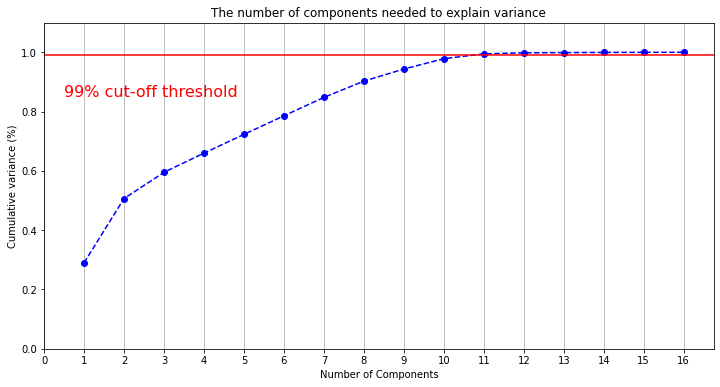

In [8]:
% matplotlib inline
import matplotlib.pyplot as plt

pca = PCA().fit(X_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(features.columns) + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(features.columns) + 1, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

We can see that using more than 9 features will not describe data any better (in a considerable amount)

In [9]:
pca = PCA(n_components = 0.99) # we want 99% variance
pca.fit(X_rescaled)
pcs = pca.transform(X_rescaled)
pcs = pd.DataFrame(pcs, columns=['pc{}'.format(x) for x in range(1, pcs.shape[1] + 1)])
pca_df = s_df.copy().join(pcs)
pca_df

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,rx,rx_with_rebates,rx_without_rebates,spec_cap,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
0,1,F,21/06/1990,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,0,0,2721.85,3611.21,2.02,632.13,82.13,474.83,0.0,3507.00,0.00,7.92,0.00,0.00,0.00,843.78,-2.060583,0.824872,-0.004248,-0.117194,1.079880,-0.414306,-1.128699,-0.332625,-0.152954,0.104068,-0.023349
1,2,M,02/01/1948,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,0,0,5060.21,6817.97,5.24,2535.98,205.93,457.04,0.0,6204.84,0.00,8.13,11289.69,10688.46,10859.82,906.77,-0.538132,2.308020,-0.162078,0.160916,1.004572,-0.505001,-0.653621,-0.542255,-0.268169,-0.017653,-0.948367
2,3,M,14/06/1948,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,0,0,3159.82,3443.32,3.17,595.96,59.13,482.63,0.0,4012.46,0.00,7.92,0.00,0.00,0.00,815.84,-2.021013,0.774359,0.021017,-0.213783,1.008321,-0.327783,-1.204599,-0.207124,-0.106009,0.221016,-0.010480
3,4,M,10/02/1954,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,0,0,9563.23,11015.31,9.92,181.95,265.65,469.04,0.0,9770.61,0.00,8.30,73.88,62.87,64.91,846.26,-0.614255,-0.094793,-0.097467,-0.155423,0.475425,-0.317730,-0.582757,-0.382310,-0.156395,-0.126012,0.148276
4,5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,0,0,17456.26,17590.58,25.55,810.83,210.62,527.98,0.0,19976.13,8875.80,8.90,522.48,517.56,606.01,867.55,1.722480,-0.798390,1.205922,2.789710,0.867564,-0.728749,0.511470,2.803693,-1.539864,0.897382,0.421466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10525,10526,F,07/04/1954,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,0,0,4526.14,5397.12,4.53,634.53,198.45,715.02,0.0,5097.30,0.00,8.94,317.71,292.58,279.22,989.74,-1.561576,0.624378,-0.904926,0.887415,0.295504,-0.325554,0.712167,-0.426157,0.234999,-0.290830,-0.038917
10526,10527,F,08/12/1945,2020,202006,SaludVIP,NON-SNP,NaN,93,HMO,0,0,9482.67,10766.42,13.85,230.99,402.95,725.39,0.0,11278.18,0.00,8.93,238.86,234.95,248.51,1002.72,-0.234060,-0.212308,-1.010718,0.786366,0.100631,-0.555446,0.688105,-0.539041,0.269079,-0.649292,0.115762
10527,10528,M,08/06/1950,2020,202006,SaludVIP,NON-SNP,MEDICARE - CAREFREE,93,HMO,0,0,17184.32,20633.83,28.16,115.47,255.70,758.40,0.0,21917.27,0.00,9.04,0.00,0.00,0.00,840.19,1.357222,-1.271033,-0.970132,0.183203,-0.519458,0.015392,0.377390,0.164767,0.552645,0.609016,-0.093296
10528,10529,M,12/10/1949,2020,202006,SaludVIP,NON-SNP,MEDICARE - CAREFREE,93,HMO,0,0,9483.41,12054.95,16.80,330.22,174.11,673.08,0.0,11212.60,364.93,8.96,529.86,638.28,641.81,868.84,-0.334426,-0.164915,-0.628645,0.433487,-0.143511,-0.035663,0.399963,0.086056,0.227930,0.331332,0.048289


In [10]:
print(pca.explained_variance_ratio_)

[0.29000241 0.21670937 0.08846896 0.06483337 0.06307091 0.06266596
 0.06214924 0.05486588 0.04069136 0.03493352 0.01623773]


## Correlation matrix

Correlation matrix allows us to select linearly independent features (a subset of all the features)\
It will be less effective compared to using PCA, but it simplifies describing features to business people

In [11]:
from scipy.stats import spearmanr

def build_correlation_matrix(df):
    df_cols = pd.DataFrame(columns=df.columns)
    p_values = df_cols.transpose().join(df_cols, how="outer")
    for r in df.columns:
        for c in df.columns:
            if r == c:
                p_values[r][c] = (-2, 0)
            else:
                p_values[r][c] = tuple(round(i, 4) for i in spearmanr(df[r], df[c]))

    return p_values

In [12]:
X_rescaled_df = pd.DataFrame(X_rescaled, columns=c_names)
corr = build_correlation_matrix(X_rescaled_df)
corr.style.apply(lambda x: ["background: yellow" if v[0] > 0.9 and v[1] < 0.05 else "" for v in x], axis=1)

,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,rx,rx_with_rebates,rx_without_rebates,spec_cap
esrd,"(-2, 0)","(-0.0022, 0.825)","(0.078, 0.0)","(0.0791, 0.0)","(0.0227, 0.0199)","(-0.0387, 0.0001)","(0.0568, 0.0)","(0.0036, 0.7154)","(-0.0006, 0.953)","(0.0783, 0.0)","(0.0246, 0.0115)","(-0.0058, 0.5504)","(0.05, 0.0)","(0.05, 0.0)","(0.0502, 0.0)","(0.0028, 0.775)"
hospice,"(-0.0022, 0.825)","(-2, 0)","(-0.073, 0.0)","(-0.0733, 0.0)","(-0.053, 0.0)","(0.0577, 0.0)","(0.0275, 0.0048)","(-0.0549, 0.0)","(-0.0086, 0.3758)","(-0.073, 0.0)","(-0.0132, 0.1766)","(-0.0085, 0.3854)","(-0.0047, 0.6329)","(-0.0046, 0.6347)","(-0.0051, 0.6024)","(-0.0037, 0.7041)"
ipa_funding,"(0.078, 0.0)","(-0.073, 0.0)","(-2, 0)","(0.9908, 0.0)","(0.9662, 0.0)","(-0.5861, 0.0)","(0.7479, 0.0)","(0.0331, 0.0007)","(0.0542, 0.0)","(0.9911, 0.0)","(0.2233, 0.0)","(-0.0128, 0.1889)","(0.3991, 0.0)","(0.3989, 0.0)","(0.3988, 0.0)","(0.0251, 0.0101)"
ma_premium,"(0.0791, 0.0)","(-0.0733, 0.0)","(0.9908, 0.0)","(-2, 0)","(0.9672, 0.0)","(-0.5895, 0.0)","(0.735, 0.0)","(0.0342, 0.0004)","(0.0521, 0.0)","(0.9908, 0.0)","(0.2215, 0.0)","(-0.0125, 0.1979)","(0.3964, 0.0)","(0.3962, 0.0)","(0.3961, 0.0)","(0.0279, 0.0042)"
ma_risk_score,"(0.0227, 0.0199)","(-0.053, 0.0)","(0.9662, 0.0)","(0.9672, 0.0)","(-2, 0)","(-0.5837, 0.0)","(0.7007, 0.0)","(0.0398, 0.0)","(0.0532, 0.0)","(0.9668, 0.0)","(0.2103, 0.0)","(-0.0132, 0.1751)","(0.3888, 0.0)","(0.3887, 0.0)","(0.3886, 0.0)","(-0.0052, 0.5927)"
mbr_with_rx_rebates,"(-0.0387, 0.0001)","(0.0577, 0.0)","(-0.5861, 0.0)","(-0.5895, 0.0)","(-0.5837, 0.0)","(-2, 0)","(-0.3393, 0.0)","(0.0007, 0.9463)","(0.08, 0.0)","(-0.5854, 0.0)","(0.1901, 0.0)","(-0.0009, 0.9294)","(0.1973, 0.0)","(0.1976, 0.0)","(0.1976, 0.0)","(0.0916, 0.0)"
partd_premium,"(0.0568, 0.0)","(0.0275, 0.0048)","(0.7479, 0.0)","(0.735, 0.0)","(0.7007, 0.0)","(-0.3393, 0.0)","(-2, 0)","(-0.0442, 0.0)","(0.1018, 0.0)","(0.748, 0.0)","(0.2461, 0.0)","(-0.0165, 0.0899)","(0.4185, 0.0)","(0.4183, 0.0)","(0.4183, 0.0)","(0.0315, 0.0012)"
pcp_cap,"(0.0036, 0.7154)","(-0.0549, 0.0)","(0.0331, 0.0007)","(0.0342, 0.0004)","(0.0398, 0.0)","(0.0007, 0.9463)","(-0.0442, 0.0)","(-2, 0)","(-0.2794, 0.0)","(0.034, 0.0005)","(-0.128, 0.0)","(-0.0007, 0.9407)","(-0.0359, 0.0002)","(-0.036, 0.0002)","(-0.0356, 0.0003)","(-0.0604, 0.0)"
pcp_ffs,"(-0.0006, 0.953)","(-0.0086, 0.3758)","(0.0542, 0.0)","(0.0521, 0.0)","(0.0532, 0.0)","(0.08, 0.0)","(0.1018, 0.0)","(-0.2794, 0.0)","(-2, 0)","(0.054, 0.0)","(0.436, 0.0)","(-0.0105, 0.2794)","(0.098, 0.0)","(0.0984, 0.0)","(0.0982, 0.0)","(-0.0558, 0.0)"
plan_premium,"(0.0783, 0.0)","(-0.073, 0.0)","(0.9911, 0.0)","(0.9908, 0.0)","(0.9668, 0.0)","(-0.5854, 0.0)","(0.748, 0.0)","(0.034, 0.0005)","(0.054, 0.0)","(-2, 0)","(0.2242, 0.0)","(-0.0124, 0.2037)","(0.401, 0.0)","(0.4008, 0.0)","(0.4007, 0.0)","(0.0282, 0.0038)"


All the yellow areas are linearly dependant (we can be sure because p-value is less than 0.05). So there is no use in keeping them as they are described by othe features

By removing all the unnecessary features we end up with only 9 of them\
Same as PCA but they are less descriptive

In [13]:
from collections import Counter

relevant_columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):

        # check correlation and corresponding p-value
        if corr.iloc[i,j][0] > 0.9 and corr.iloc[i,j][1] < 0.05:
            if relevant_columns[j]:
                relevant_columns[j] = False

relevant_columns = X_rescaled_df.columns[relevant_columns]
corr_features = X_rescaled_df[relevant_columns]
corr_features

,esrd,hospice,ipa_funding,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,prof,reinsurance,rx,spec_cap
0,-0.050702,-0.042516,-1.032013,0.116503,-0.833781,-0.122654,-0.159708,-0.227893,-1.597836,-0.159689,0.235903
1,-0.050702,-0.042516,-0.727928,1.800611,-0.316101,-0.188684,-0.159708,-0.227893,-1.182722,0.672307,0.702600
2,-0.050702,-0.042516,-0.975058,0.084508,-0.929958,-0.093703,-0.159708,-0.227893,-1.597836,-0.159689,0.028893
3,-0.050702,-0.042516,-0.142346,-0.281717,-0.066377,-0.144144,-0.159708,-0.227893,-0.846678,-0.154245,0.254277
4,-0.050702,-0.042516,0.884079,0.274578,-0.296490,0.074619,-0.159708,4.738765,0.339361,-0.121185,0.412016
...,...,...,...,...,...,...,...,...,...,...,...
10525,-0.050702,-0.042516,-0.797379,0.118626,-0.347379,0.768840,-0.159708,-0.227893,0.418431,-0.136276,1.317330
10526,-0.050702,-0.042516,-0.152823,-0.238337,0.507755,0.807330,-0.159708,-0.227893,0.398663,-0.142086,1.413500
10527,-0.050702,-0.042516,0.848715,-0.340524,-0.107984,0.929850,-0.159708,-0.227893,0.616104,-0.159689,0.209304
10528,-0.050702,-0.042516,-0.152726,-0.150560,-0.449159,0.613175,-0.159708,-0.023688,0.457965,-0.120641,0.421574


# Finding outliers

 ## Finding outliers using Interquartile range

 IQR is a statistical approach in finding outliers\
 The reason for using it is that it is not affected by extreme values

### Utilizing pca features


In [14]:
def get_outliers(feature_df, init_df, IQR):
    IQR, Q1, Q3 = IQR
    outliers = list()
    for c_name in feature_df.columns:
        outliers.append(init_df[init_df[c_name].map(lambda x: x < (Q1[c_name] - 1.5 * IQR[c_name]) or x > (Q3[c_name] + 1.5 * IQR[c_name]))])
    outliers = pd.concat(outliers).drop_duplicates('member_unique_id')
    outliers = data.loc[list(outliers.index.values),]
    return outliers

def calculate_IQR(feature_df, init_df):
    # Calculate midspread of data
    Q1 = init_df[feature_df.columns].quantile(0.25)
    Q3 = init_df[feature_df.columns].quantile(0.75)
    IQR = Q3 - Q1
    return IQR, Q1, Q3

In [15]:
pca_IQR = calculate_IQR(pcs, pca_df)
pca_outliers = get_outliers(pcs, pca_df, pca_IQR)
pca_outliers

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
62,63,M,29/06/1944,2020,202006,Affiliate,D-SNP,NaN,1,HMO,False,False,"$43,965.67","$43,457.05",$48.03,$862.64,$691.94,$523.56,$0.00,"$52,110.53",$0.00,$9.48,$0.00,"$27,513.95",$0.00,"$30,963.89","$32,025.88",$957.09
107,108,M,18/05/1956,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,False,False,"$32,605.21","$35,347.82",$45.85,"$1,106.89","$1,887.93",$510.73,$0.00,"$36,986.52",$0.00,$8.82,$0.00,"$34,279.67",$0.00,"$35,680.20","$35,819.58",$818.94
130,131,F,07/03/1968,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,2,HMO,False,False,"$13,007.14","$13,958.33",$14.03,"$12,612.16","$1,992.34",$671.79,$0.00,"$15,987.45",$0.00,$9.62,$0.00,"$180,462.51",$0.00,"$155,800.97","$170,609.15",$794.62
140,141,F,09/11/1940,2020,202006,Affiliate,D-SNP,NaN,2,HMO,False,False,"$30,525.51","$34,712.12",$44.19,$65.13,$505.24,$563.52,$0.00,"$36,408.19",$0.00,$9.03,$0.00,$316.47,$0.00,$336.75,$382.84,$747.75
167,168,M,01/08/1959,2020,202006,Affiliate,D-SNP,NaN,2,HMO,False,False,"$37,149.57","$44,518.80",$55.58,$42.71,$395.93,$501.82,$0.00,"$47,463.05",$0.00,$8.77,$0.00,$160.12,$0.00,$179.58,$171.36,$750.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10155,10156,F,13/09/1954,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,89,HMO,False,False,"$4,175.60","$4,755.66",$4.60,"$1,176.11",$86.39,$476.64,$0.00,"$4,965.85",$0.00,$9.32,$0.00,"$2,129.53",$0.00,"$2,154.86","$2,102.76",$961.89
10268,10269,M,25/07/1966,2020,202006,VIPcare,NON-SNP,MEDICARE - CAREFREE,91,HMO,False,False,"$2,830.70","$3,122.14",$2.15,"$1,521.53",$84.06,$737.62,$0.00,"$2,974.55",$0.00,$9.52,$0.00,"$1,957.70",$0.00,"$2,205.71","$2,298.81","$1,093.30"
10277,10278,F,21/07/1954,2020,202006,VIPcare,NON-SNP,NaN,91,HMO,False,False,"$8,649.36","$9,598.50",$9.35,"$1,787.43",$195.00,$643.97,$0.00,"$10,795.27",$0.00,$8.25,$0.00,"$13,750.33",$0.00,"$13,963.51","$12,634.32","$1,017.05"
10287,10288,M,09/12/1967,2020,202006,VIPcare,NON-SNP,MEDICARE - CAREFREE,91,HMO,False,False,"$2,776.92","$3,268.86",$1.90,"$1,027.87",$80.30,$684.93,$0.00,"$3,492.15",$0.00,$8.06,$0.00,$298.80,$0.00,$289.62,$260.13,"$1,024.78"


### Utilizing features found by correlation matrix

In [16]:
corr_IQR = calculate_IQR(corr_features, s_df)
corr_outliers = get_outliers(corr_features, s_df, corr_IQR)
corr_outliers

,member_unique_id,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,hospice,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
783,784,F,22/09/1941,2020,202006,Affiliate,NON-SNP,NaN,6,HMO,True,False,"$71,206.30","$92,852.12",$12.93,$133.90,$382.55,$0.00,$0.00,"$95,892.34",$0.00,$9.06,$0.00,"$8,200.42",$0.00,"$8,692.28","$8,459.38",$775.88
997,998,M,07/07/1945,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,10,HMO,True,False,"$78,255.41","$107,819.48",$14.25,$81.86,$307.07,$695.13,$0.00,"$96,601.55",$0.00,$7.95,$0.00,"$5,830.91",$0.00,"$5,060.15","$5,143.91","$1,137.82"
1326,1327,M,16/07/1939,2020,202006,Affiliate,NON-SNP,NaN,11,HMO,True,False,"$51,803.87","$61,296.80",$8.52,$160.66,$283.70,$548.45,$0.00,"$57,892.90","$8,428.67",$8.44,$0.00,$70.66,$0.00,$74.80,$71.38,$683.56
1604,1605,M,22/11/1956,2020,202006,VIPcare,D-SNP,MEDICARE - CARENEEDS,14,HMO,True,False,"$64,346.45","$70,358.57",$9.17,$189.84,"$1,090.98",$684.93,$0.00,"$71,504.54",$0.00,$8.22,$0.00,"$9,568.54",$0.00,"$9,073.29","$9,863.11",$781.02
1696,1697,F,28/03/1959,2020,202006,VIPcare,D-SNP,NaN,15,HMO,True,False,"$71,199.47","$81,391.23",$11.54,$355.49,$680.87,$666.03,$0.00,"$90,285.20","$8,666.70",$8.78,$0.00,"$12,728.56",$0.00,"$14,221.93","$13,221.61",$763.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10345,10346,M,23/08/1937,2020,202006,VIPcare,NON-SNP,MEDICARE - CAREFREE,91,HMO,False,False,"$4,365.55","$4,544.92",$4.77,$524.26,$32.00,$669.22,$0.00,"$5,268.28",$0.00,$8.05,$0.00,$0.00,$0.00,$0.00,$0.00,"$1,198.99"
10347,10348,F,18/01/1966,2020,202006,VIPcare,NON-SNP,MEDICARE - CAREFREE,91,HMO,False,False,"$3,103.32","$3,475.17",$2.86,$664.26,$86.98,$717.95,$0.00,"$4,190.57",$0.00,$8.96,$0.00,$0.00,$0.00,$0.00,$0.00,"$1,180.62"
10353,10354,F,25/07/1943,2020,202006,VIPcare,D-SNP,MEDICARE - CARENEEDS,91,HMO,False,False,"$21,747.74","$22,622.42",$30.35,$136.01,$264.55,$665.40,$0.00,"$24,885.47",$0.00,$9.39,$0.00,$478.88,$0.00,$410.72,$400.59,"$1,183.21"
10356,10357,F,19/07/1949,2020,202006,VIPcare,NON-SNP,NaN,91,HMO,False,False,"$6,408.75","$6,727.88",$6.42,$442.39,$56.74,$691.70,$0.00,"$7,637.92",$0.00,$8.39,$0.00,$0.00,$0.00,$0.00,$0.00,"$1,165.32"


# Explanation

PCA features are more reliable and descriptive than feature found by Correlation.

**Principal components** reduce dimensionality of data. In example we have a set of points in 3d space. What PCA does - it finds such vectors that are orthogonal to each other in that space - those vectors are our components.

Features found by **correlation** are the subset of initial features. It makes sure that our columns do not depend on each other (as it does not have any statistical meaning).